<a href="https://colab.research.google.com/github/IFuentesSR/FES_drought/blob/main/Gringerton_SRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Connection to GEE

In [2]:
# Import, authenticate and initialize the Earth Engine library.
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=o29akgKeQemB4P49eisb1LTbGI5glo8q0wPVjn7HSOg&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWjAdfvrZOz0rGQ9MgbzzYLEfeudl070AMTgTq7vQmMZ0HXbjGVudYk

Successfully saved authorization token.


## Importing libraries

In [3]:
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Importing ERA5 runoff

In [5]:
era5 = ee.ImageCollection("ECMWF/ERA5_LAND/MONTHLY")
runoff = era5.select('runoff')

## Function and parameter definition

In [24]:
c0 = 2.515517
c1 = 0.802853
c2 = 0.010328
d1 = 1.432788
d2 = 0.189269
d3 = 0.001308
years = ee.List.sequence(1981, 2021)
months = ee.List.sequence(1, 12)


def monthly_scale(img):
    props = img.propertyNames()
    image = img.multiply(ee.Image.pixelArea()).copyProperties(img, props)
    return image.set('month', 
                     ee.Date(img.get('system:time_start')).get('month'))


def get_sample(geometry):
    def wrap(img):
        date = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd')
        sri_value = img.reduceRegion('first', geometry, 25000).values().get(0)
        return ee.Feature(None, {'date':date, 'sri':sri_value})
    return wrap
    

def normInv(cummProb):
  return cummProb.multiply(2).subtract(1).erfInv().multiply(ee.Image(2).sqrt())


def agg_runoff(collection, scale):
    def inner(year):
        months = ee.List.sequence(1,12)
        def month_iteration(m):
            date = ee.Date.fromYMD(year, m, 1)
            coll = collection.filterDate(date.advance(ee.Number(scale).multiply(-1), 'month'), date)
            cond = ee.Algorithms.If(coll.size().lt(scale),
                                    ee.Image(0).set('drop', 1),
                                    coll.sum().set('drop', 0))
            return ee.Image(cond).setMulti({'system:time_start': date.millis(), 'date':date.format('YYYY_MM_dd'), 'month':ee.Number(m)})
        return months.map(month_iteration)
    return inner


def get_sri(collection):
    def inner(month):
        collection1 = collection.filter(ee.Filter.eq('month', month))
        len = collection1.size()
        def wrap(year):
            date = ee.Date.fromYMD(year, month, 1)
            img = collection1.filterDate(date, date.advance(1, 'month')).first()
            cond = collection1.toBands().lte(img)
            combi = cond.reduce(ee.Reducer.sum())
            gringer = (combi.subtract(0.44)).divide(ee.Image(len).add(0.12)).rename('P')
            t1 = ee.Image(1).divide(gringer.pow(2)).log().sqrt()
            t2 = ee.Image(1).divide((ee.Image(1).subtract(gringer)).pow(2)).log().sqrt()
            s1 = t1.expression('-1 * (t1 - ((c0 + c1*t1 + c2*t1**2)/(1 + d1*t1 + d2*t1**1 + d3*t1**3)))',
                               {'t1': t1, 'c0':c0, 'c1':c1, 'c2':c2,
                                'd1':d1, 'd2':d2, 'd3':d3})
            s2 = t2.expression('t2 - ((c0 + c1*t2 + c2*t2**2)/(1 + d1*t2 + d2*t2**1 + d3*t2**3))',
                               {'t2': t2, 'c0':c0, 'c1':c1, 'c2':c2,
                                'd1':d1, 'd2':d2, 'd3':d3})
            SI = s1.where(gringer.gt(0.5), s2)
            return SI.setMulti({'system:time_start': date.millis(),
                                'date':date.format('YYYY_MM_dd'),
                                'month':month,
                                'drop':img.get('drop')})
        return years.map(wrap)
    return months.map(inner)


## Running functions to aggregate runoff and create standardised runoff

In [29]:
ro = years.map(agg_runoff(runoff, 3))
ro = ee.ImageCollection.fromImages(ro.flatten()).sort('system:time_start')
sri = get_sri(ro)
sri3 = ee.ImageCollection.fromImages(sri.flatten()).filter(ee.Filter.eq('drop', 0)).sort('system:time_start')

## Mapping SRI for April 2005

In [30]:
id = sri3.filterDate('2005-04-01', '2012-01-01').first().getMapId({'min': -2, 'max': 2, 'palette':'FF0000, FFFFFF, 0000FF'})
map = folium.Map(location=[-30.63, 149.91], zoom_start=2)
folium.TileLayer(
    tiles=id['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='SRI_April2004',
  ).add_to(map)
map.add_child(folium.LayerControl())
map

## Sampling SRI time series in one location

In [31]:
geo = ee.Geometry.Point([149.5462, -30.2282])
series = sri3.map(get_sample(geo)).getInfo()

ixs = [n['properties']['sri'] for n in series['features']]
time = [pd.to_datetime(n['properties']['date'], format='%Y-%m-%d') for n in series['features']]
df = pd.DataFrame(data={'sri':ixs, 'date':time})
d = np.zeros(len(ixs))

## Time series of 3-month SRI

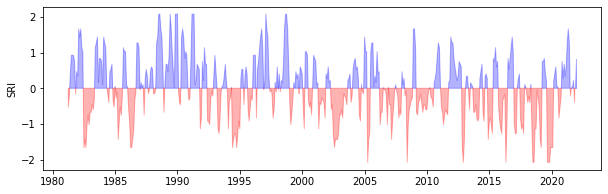

In [32]:
fig, axs = plt.subplots(figsize=(10, 3))
axs.fill_between(time, d, ixs, where=df['sri']>=d, interpolate=True, color='blue', alpha=0.3, label='SRI')
axs.fill_between(time, d, ixs, where=df['sri']<=d, interpolate=True, color='red', alpha=0.3)
axs.set_ylabel('SRI')
fig.show()